# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [66]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
import pandas as pd

Load feature names.

In [3]:
feature_names = []
with open('C:/Users/Lucy/Documents/Berkeley MIDS/W207 Applied Machine Learning/amit-coursework/Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print('Loaded feature names:', len(feature_names))

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [5]:
X, Y = [], []

with open('C:/Users/Lucy/Documents/Berkeley MIDS/W207 Applied Machine Learning/amit-coursework/Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

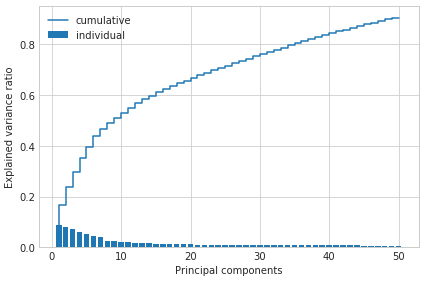

In [17]:
def P1():
### STUDENT START ###

    # First scale the data
    from sklearn.preprocessing import StandardScaler
    train_data_scl = StandardScaler().fit_transform(train_data)

    # Run PCA on the scaled data
    pca = PCA()
    pca.fit(train_data_scl)

    # Get each explained variance ratio from pca and calculate cumulative variance
    var = pca.explained_variance_ratio_[0:50]
    cum_var = np.cumsum(var)

    # Plot the variance and cum variance for each value of k
    k = range(1,51)
    with plt.style.context('seaborn-whitegrid'):
        plt.bar(k, var, label='individual')
        plt.step(k, cum_var, label='cumulative')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal components')
        plt.legend(loc='best')
        plt.tight_layout()


### STUDENT END ###

P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

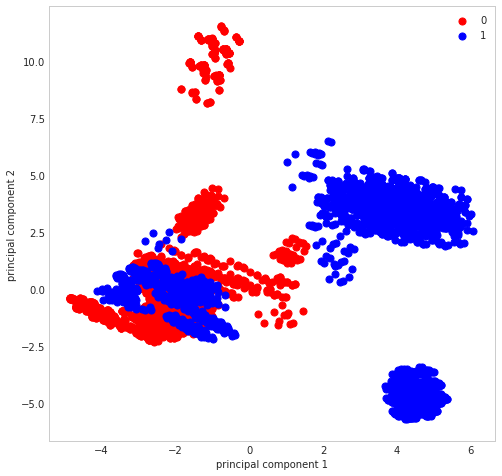

In [30]:
def P2():
### STUDENT START ###

    # Fit and transform the training data into 2 principal components
    pca2 = PCA(n_components=2)
    principalComponents = pca2.fit_transform(train_data_scl)

    # Create dataframe of prinicpal components and add in the target values
    pc_df = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    labels_df = pd.DataFrame(data = train_labels, columns = ['labels'])
    df = pd.concat([pc_df, labels_df], axis=1)

    # Plot the results
    with plt.style.context('seaborn-whitegrid'):
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel('principal component 1')
        ax.set_ylabel('principal component 2')
        targets = [0, 1]
        colors = ['r', 'b']
        for target, color in zip(targets,colors):
            indices = df['labels'] == target
            ax.scatter(df.loc[indices, 'principal component 1']
                       , df.loc[indices, 'principal component 2']
                       , c = color
                       , s = 50)
        ax.legend(targets)
        ax.grid()
### STUDENT END ###

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

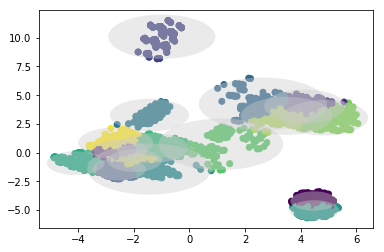

In [55]:
def P3():
### STUDENT START ###
    from scipy.spatial.distance import cdist

    # Fit and assign kmeans clusters
    kmeans = KMeans(n_clusters=16,init='k-means++')
    kmeans_labels = kmeans.fit_predict(pc_df)

    #  Plot the data by cluster
    plt.scatter(df['principal component 1'], df['principal component 2'], c=kmeans_labels)

    # Plot the circle that goes through the most distant point in each cluster
    ax = plt.gca()
    centers = kmeans.cluster_centers_
    radii = [cdist(pc_df[kmeans_labels == i], [center]).max() for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', alpha=0.4, zorder=1))

### STUDENT END ###

P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

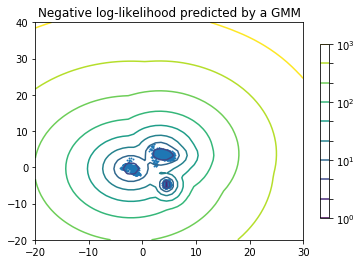

In [71]:
def P4():
### STUDENT START ###

    # Create dataframe with positive labels only
    pos_indices = df['labels']==1
    pos_pc_1 = df.loc[indices, 'principal component 1']
    pos_pc_2 = df.loc[indices, 'principal component 2']
    pc_df_pos = pd.concat([pos_pc_1, pos_pc_2], axis=1)

    # NOTE: Since GMM is deprecated, I used GaussianMixture instead
    # Fit a Gaussian Mixture Model with 4 components (student's note: I tried different components and covariance matrix types
    # but only displayed what is below)
    gmm = GaussianMixture(n_components=4, covariance_type='diag')
    gmm.fit(pc_df_pos)

    # Display predicted scores by the model as a contour plot
    x = np.linspace(-20., 30.)
    y = np.linspace(-20., 40.)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -gmm.score_samples(XX)
    Z = Z.reshape(X.shape)
    CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 10))
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    plt.scatter(pc_df_pos['principal component 1'], pc_df_pos['principal component 2'], .8)
    plt.title('Negative log-likelihood predicted by a GMM')
    plt.axis('tight')
    plt.show()

### STUDENT END ###

P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [93]:
def P5():
### STUDENT START ###

    # Fit a 4-component full covariance GMM on the positive labels only
    gmm_pos = GaussianMixture(n_components=4, covariance_type='full')
    gmm_pos.fit(pc_df_pos)

    # Create dataframe with negative labels only
    neg_indices = df['labels']==0
    neg_pc_1 = df.loc[indices, 'principal component 1']
    neg_pc_2 = df.loc[indices, 'principal component 2']
    pc_df_neg = pd.concat([neg_pc_1, neg_pc_2], axis=1)

    # Fit a 4-component full covariance GMM on the negative labels only
    gmm_neg = GaussianMixture(n_components=4, covariance_type='full')
    gmm_neg.fit(pc_df_neg)

    # Before predicting on test data, must first reduce to 2 dimensions
    # Fit and transform the training data into 2 principal components
    test_data_scl = StandardScaler().fit_transform(test_data)
    principalComponents_test = pca2.transform(test_data_scl)
    pc_df_test = pd.DataFrame(data = principalComponents_test, columns = ['principal component 1', 'principal component 2'])

    # Predict the test data on both models and get the probability for each sample, transforming the log probs 
    pos_predict = gmm_pos.predict(pc_df_test)
    pos_score = np.exp(gmm_pos.score_samples(pc_df_test))
    neg_predict = gmm_neg.predict(pc_df_test)
    neg_score = np.exp(gmm_neg.score_samples(pc_df_test))

    # Create an array that compares the pos_score and neg_score for each label, then chooses the predict for the larger probability
    pos_pred = np.where(pos_score>neg_score)
    neg_pred = np.where(neg_score>=pos_score)
    pred = np.zeros(test_labels.shape[0])
    pred[pos_pred]=pos_predict[pos_pred]
    pred[neg_pred]=neg_predict[neg_pred]

    # Calculate the accuracy score
    metrics.accuracy_score(test_labels, pred)

### STUDENT END ###

P5()

0.12544483985765126

(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [104]:
def P6():
### STUDENT START ###

    # Define a few functions to help with this...
    def reduce_pca(n):

        # Fit and transform the training data into 2 principal components
        pca = PCA(n_components=n)
        principalComponents = pca.fit_transform(train_data_scl)

        # Create dataframe of prinicpal components
        pc_df = pd.DataFrame(data = principalComponents)

        return pc_df

    def predict_gmm(n, cov_type='full'):

        gmm = GaussianMixture(n_components=n, covariance_type='full')
        gmm.fit(pc_df)
        pred = gmm.predict(pc_df_test)

        return pred

    # Create some input vectors to try
    pca_comp = [2,3,4]
    gmm_comp = [2,3,4]
    gmm_covtype = ['full','diag','tied', 'spherical']

    # Iterate through every combination of the input vectors and find the parameters that give the highest accuracy
    best_acc = 0.0
    best_i = 4
    best_j = 3
    best_k = 'full'
    for i in pca_comp:
        for j in gmm_comp:
            for k in gmm_covtype:
                df = reduce_pca(i)
                df_pred = predict_gmm(j, k)
                acc = metrics.accuracy_score(test_labels, df_pred)
                if acc>best_acc:
                    best_acc = acc
                    best_i = i
                    best_j = j
                    best_k = k

    print("Best accuracy: ", best_acc)
    print("Number of PCA components: ", best_i)
    print("Number of GMM components: ", best_j)
    print("Covariance type: ", best_k)

### STUDENT END ###

P6()

Best accuracy:  0.859430604982
Number of PCA components:  2
Number of GMM components:  2
Covariance type:  diag
